In [1]:
import torch
from torch import nn # nn contains all of pyTorch's building blocks for nueral networks
import matplotlib.pyplot as plt
import numpy as np

print(torch.__version__)

2.2.0


## 1. Data (Preparing and Loading)

- Use linear regression to make a straight line with known **parameters**


In [2]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # Capital for tensors and matrices small for scalar and vectors
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

- Rship btwn x and y is known
- But, build a model that looks at the data for y and x and tries to find the relationship


### Splitting data for training and testing


In [3]:
train_split = int(0.8 * len(X))

train_split

40

In [4]:
X_train, y_train = X[:train_split], y[:train_split] # up until the train split
X_test, y_test = X[train_split:], y[train_split:] # the train split onwards

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### Function to visualize our data


In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test_data and compares predictions.
    """

    plt.figure(figsize=(10, 7))
    
    # train data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

    # train data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label="Training data")

    # Are there predictions?
    if predictions is not None:
        # Plot the predictions
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")
    
    # show the legend
    plt.legend(prop={"size": 14});

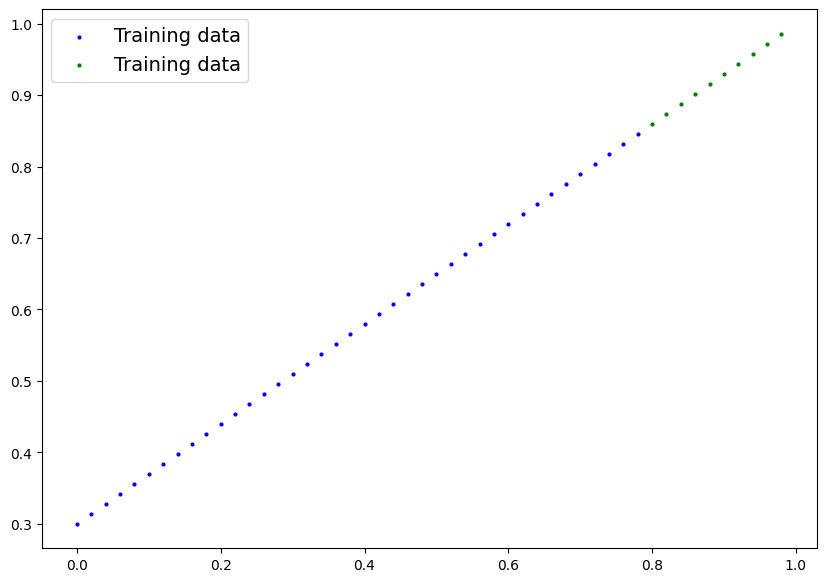

In [6]:
plot_predictions() 

### 2. Building Model

- Get familiar with OOP in python


In [7]:
# Creating linear regression model class
# The model start with random values (Weight and Bias)
# Looks at the training data and adjusts the random values to get a better representation of the ideal values
# Uses gradient descent and back propagation algos
# Search torch.nn.module

class LinearRegressionModel(nn.Module): # inherits from nn.Module
    def __init__(self):
        super().__init__()

        # Initialize model parameters
        self.weights = nn.Parameter(torch.randn(1,
                                               requires_grad=True,
                                               dtype=torch.float))
        
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
        
        # Override the Forward method to define the computation in the model
    def forward(self, x: torch.tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [8]:
# Different value each time

torch.randn(1)

tensor([-0.4847])

In [9]:
# Same value all the time

torch.manual_seed(42)
torch.randn(1)

tensor([0.3367])

In [10]:
# Create a random seed
torch.manual_seed(42)

# Creating an instance for our LinearRegressionModel
model_1 = LinearRegressionModel()

# Check out the list parameters
list(model_1.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [11]:
# List named parameters
model_1.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [12]:
# Check our models predictive power
# Inference mode turns off the gradient tracking
# PyTorch will be a lot faster

with torch.inference_mode():
    y_preds = model_1(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [13]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

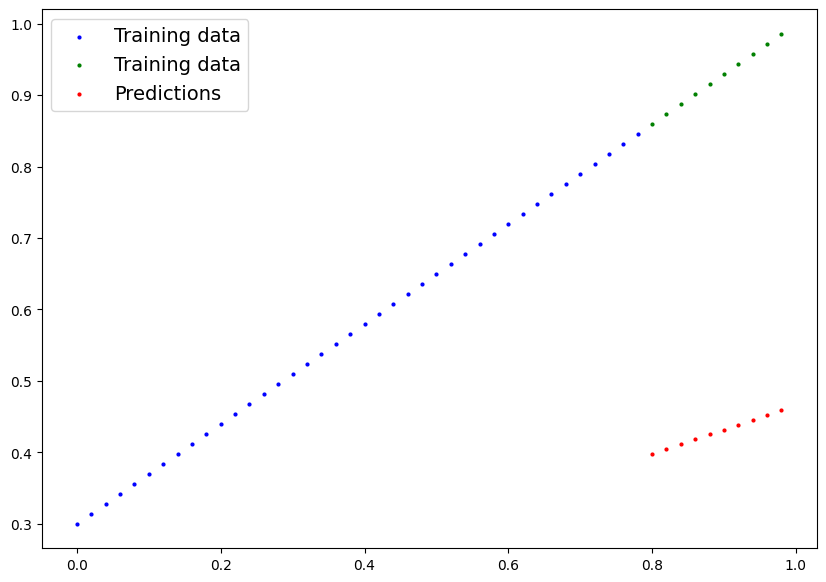

In [14]:
# Random predictions are far from ideal
plot_predictions(predictions=y_preds)

### 3. Train & Test Model

- **Loss Function** - Used to measure how poor the model predictions are
- **Optimizer** - Uses the loss of the model to adjust the model's parameters to improve the loss function

For pytorch

- Training loop
- Testing loop


In [15]:

model_1.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [16]:
# Set up a loss function
loss_fn = nn.L1Loss()

# Set up an optimizer - Stochastic Gradient Descent
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01) # Learning rate in our case 0.3367 to 0.3467

In [17]:
torch.manual_seed(42)

# Building a training loop
# An epoch is one loop through the data

epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# loop through the data
for epoch in range(epochs):
    # set the model to training mode (sets all require gradients to true)
    model_1.train()

    # Forward pass - data moving through our forward function
    y_pred = model_1(X_train)

    # Calculate loss
    loss = loss_fn(y_pred, y_train) # (input, target)

    # Zero gradients of the optimizers (they accumulate by default)
    optimizer.zero_grad()

    # Perform backpropagation on the loss
    loss.backward()

    # Step the optimizer (perform gradient descent)
    optimizer.step()

    ### Testing
    # Put model in evaluation mode
    model_1.eval() # Turns off different settings in the model not needed for testing (e.g dropout, batch, e.t.c)#

    with torch.inference_mode(): # (or torch.no_grad()) Turns off gradient tracking

        # Do the forward pass on test data
        test_pred = model_1(X_test)

        # Calculate the loss on the test data
        test_loss = loss_fn(test_pred, y_test)
        
        # Print out whats happening every 10 epochs
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            loss_values.append(loss)
            test_loss_values.append(test_loss)
            # Print out whats happening
            print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

            # print out model state_dict()
            print(model_1.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict({'weights': tensor([0.3406]), 'bias': tensor([0.1388])})
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict({'weights': tensor([0.3796]), 'bias': tensor([0.2388])})
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict({'weights': tensor([0.4184]), 'bias': tensor([0.3333])})
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict({'weights': tensor([0.4512]), 'bias': tensor([0.3768])})
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict({'weights': tensor([0.4748]), 'bias': tensor([0.3868])})
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict({'weights': tensor([0.4938]), 'bias': tensor([0.3843])})
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict({'weights': tensor([0.5116]), 'bias': tensor([0.3788])})
Epoch: 70 | Loss: 0.03

Text(0.5, 0, 'Epoch')

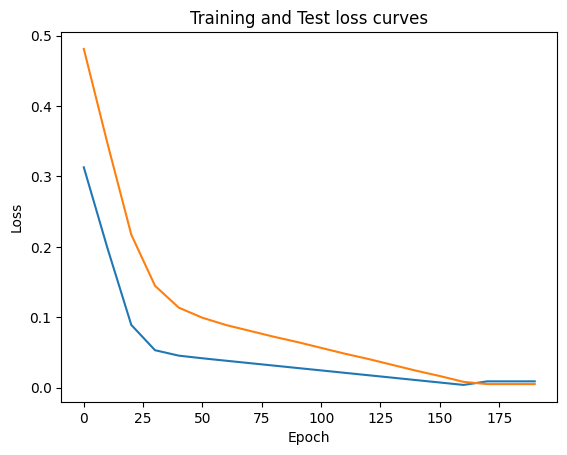

In [18]:
# Plot loss values
# Matplotlib works with numpy
loss_values_np = np.array(torch.tensor(loss_values).cpu().numpy())

plt.plot(epoch_count, loss_values_np, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and Test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")

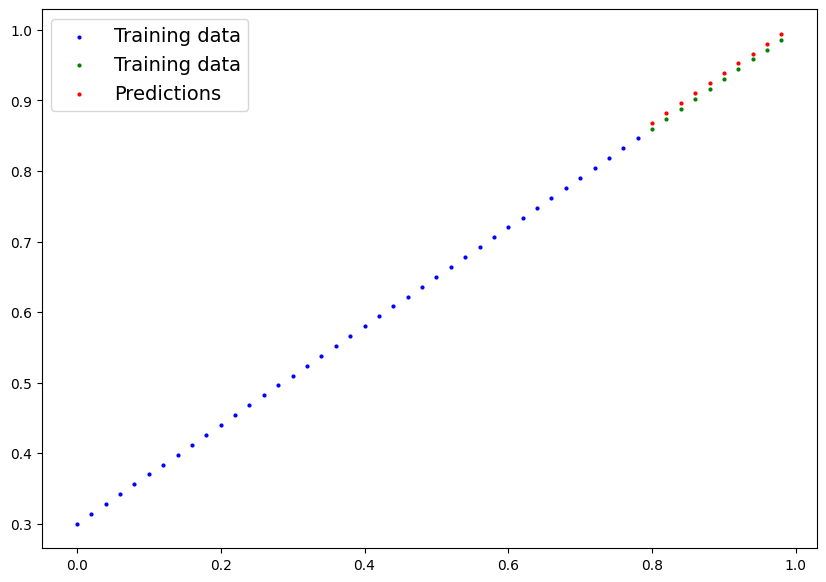

In [19]:
# Visualize
with torch.inference_mode():
    y_preds_new = model_1(X_test)

plot_predictions(predictions=y_preds_new)

### Saving a model in PyTorch

3 main methods

1. `torch.save()` - Save PyTorch object in pickle format
2. `torch.load()` - Load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - load a model's saved state dictionary


In [20]:
# Saving our PyTorch model
from pathlib import Path

# Creates models directory
# Path.cwd() # current working directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "01_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# Save model state dict (compare with saving the entire model)
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models\01_model_1.pth


In [21]:
## Loading a PyTorch model
# since we used save state_dict() we'll need to instantiate a new model class
loaded_model_1 = LinearRegressionModel()

# Load the saved state_dict (will update the new instance with updated parameters)
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [22]:
loaded_model_1.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [23]:
# Make some predictions with our loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_1(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [24]:
# Compare loaded model preds with original model preds
test_pred == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])